<a href="https://colab.research.google.com/github/Hadavand-s-Minions/rsna-cervical-spine/blob/main/notebooks/Train_Segmentations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Necessary Libraries And Modules

These are the libraries we will need for preprocessing image data, splitting the data, training models, computing accuracy and improving model performance

In [2]:
!pip install git+https://github.com/tensorflow/examples.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-th84barq
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-th84barq
  Created wheel for tensorflow-examples: filename=tensorflow_examples-a80e61f279e77d22ac24a7888e1f24b4933014e0_-py3-none-any.whl size=299719 sha256=eb915890e0450d143d6ed3afc25cb32cd55c3161c85dddb6edfbe3c01b237d8c
  Stored in directory: /tmp/pip-ephem-wheel-cache-__l8t4ul/wheels/4e/f5/c2/bfe75b834c9028b2529023bf74541c46ead531b513a8010d21
Failed to build tensorflow-examples
    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/i

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import clear_output
import seaborn as sns
from PIL import Image
import nibabel as nib
from nibabel import Nifti1Image
from keras_preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, ParameterGrid
import tensorflow as tf
from tensorflow.python.data.ops.dataset_ops import TensorSliceDataset
from tensorflow.python.framework.ops import EagerTensor
from tensorflow_examples.models.pix2pix import pix2pix

### Mount Files from Google Drive to Read Image and Variable data for analysis

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Load the .nii files from segmentations 

We load the .nii files from the segmentations folder below. The .nii files are masked files that contain labels for the vertebrae. As will be seen in the following code cells, each image file is a 3-D containing all the vertebrae and labels 0 - 19. The mask of each slice of the image tells us which vertebrae we are currently observing. For example, we can have a mask [[0,4, 6, 7],[20000, 4999, 799, 500]]. What this means is that the vertebrae we are observing is C4 because it has the second highest count. In all cases, 0 will always have the highest count because it represents areas without images and for the segmentations, there is more area without an image than areas with images.

There are only 87 segmentation images. To train the semantic segmentation model, we will need the corresponding jpeg images so that we can identify the true mask vs the predicted mask. The goal of training a semantic segmentation model is so that the model can easily identify what a C1 - C7 vertebrae looks like since the segmentated images are labeled.

In [4]:
base_folder: str = "/content/gdrive/MyDrive/Tutorial_Session/hadavands_minions"
segmentations_folder: str = base_folder + "/segmentations_npy/"

training_folder: str = base_folder + "/train_images/"


segmentations_df = pd.DataFrame({
    "segmentations": os.listdir(segmentations_folder)
})

segmentations_df["StudyInstanceUID"] = segmentations_df[
    "segmentations"
  ].str.strip(".npy")
segmentations_df["segmentations"] = segmentations_folder + segmentations_df[
    "segmentations"
  ]


segmentations_df = segmentations_df.set_index("StudyInstanceUID")

training_df = pd.DataFrame({
    "training": os.listdir(training_folder)
})

training_df["StudyInstanceUID"] = training_df["training"]

training_df["training"] = training_folder + training_df["training"]


training_df = training_df.set_index("StudyInstanceUID")

train_df = pd.read_csv(base_folder+"/train.csv")
train_df = train_df.set_index("StudyInstanceUID")

df = pd.concat([segmentations_df, training_df, train_df], axis=1)

df

,segmentations,training,patient_overall,C1,C2,C3,C4,C5,C6,C7
StudyInstanceUID,,,,,,,,,,
1.2.826.0.1.3680043.10633,/content/gdrive/MyDrive/Tutorial_Session/hadav...,/content/gdrive/MyDrive/Tutorial_Session/hadav...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.2.826.0.1.3680043.10921,/content/gdrive/MyDrive/Tutorial_Session/hadav...,/content/gdrive/MyDrive/Tutorial_Session/hadav...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.2.826.0.1.3680043.11827,/content/gdrive/MyDrive/Tutorial_Session/hadav...,/content/gdrive/MyDrive/Tutorial_Session/hadav...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1.2.826.0.1.3680043.11988,/content/gdrive/MyDrive/Tutorial_Session/hadav...,/content/gdrive/MyDrive/Tutorial_Session/hadav...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1.2.826.0.1.3680043.12281,/content/gdrive/MyDrive/Tutorial_Session/hadav...,/content/gdrive/MyDrive/Tutorial_Session/hadav...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
1.2.826.0.1.3680043.23422,NaN,/content/gdrive/MyDrive/Tutorial_Session/hadav...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.2.826.0.1.3680043.30831,NaN,/content/gdrive/MyDrive/Tutorial_Session/hadav...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.2.826.0.1.3680043.501,NaN,/content/gdrive/MyDrive/Tutorial_Session/hadav...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Create new df with only corresponding .nii files

Since we can only train the model with the available .nii and corresponding jpeg files, we create a new dataframe by dropping all rows which do not have .nii files.

In [5]:
seg_df = df.dropna()
seg_df

,segmentations,training,patient_overall,C1,C2,C3,C4,C5,C6,C7
StudyInstanceUID,,,,,,,,,,
1.2.826.0.1.3680043.10633,/content/gdrive/MyDrive/Tutorial_Session/hadav...,/content/gdrive/MyDrive/Tutorial_Session/hadav...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.2.826.0.1.3680043.10921,/content/gdrive/MyDrive/Tutorial_Session/hadav...,/content/gdrive/MyDrive/Tutorial_Session/hadav...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.2.826.0.1.3680043.11827,/content/gdrive/MyDrive/Tutorial_Session/hadav...,/content/gdrive/MyDrive/Tutorial_Session/hadav...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1.2.826.0.1.3680043.11988,/content/gdrive/MyDrive/Tutorial_Session/hadav...,/content/gdrive/MyDrive/Tutorial_Session/hadav...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1.2.826.0.1.3680043.12281,/content/gdrive/MyDrive/Tutorial_Session/hadav...,/content/gdrive/MyDrive/Tutorial_Session/hadav...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
1.2.826.0.1.3680043.8330,/content/gdrive/MyDrive/Tutorial_Session/hadav...,/content/gdrive/MyDrive/Tutorial_Session/hadav...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
1.2.826.0.1.3680043.8574,/content/gdrive/MyDrive/Tutorial_Session/hadav...,/content/gdrive/MyDrive/Tutorial_Session/hadav...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.2.826.0.1.3680043.8744,/content/gdrive/MyDrive/Tutorial_Session/hadav...,/content/gdrive/MyDrive/Tutorial_Session/hadav...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# loop through all the seg images, load them and read them
all_segs: dict = {}
for i, seg_row in seg_df.iterrows():
  image_obj: np.memmap = np.load(seg_row["segmentations"], mmap_mode='r')
  all_segs[i] = np.flip(image_obj, axis=-1)

print(f'Type of the image {type(all_segs[i])}.')
print(f'Lenght of list {len(all_segs)}.')

Type of the image <class 'numpy.memmap'>.
Lenght of list 87.


In [7]:
# randomly select one of the images
ind = seg_df.sample().index[0]
all_segs[ind].shape

(512, 512, 303)

In [8]:
image_mask = all_segs[ind]
image_mask = image_mask

In [9]:
# image_mask: np.memmap = all_segs[ind].get_fdata()
type(image_mask)

numpy.memmap

In [10]:
height, width, depth = image_mask.shape

print(f'The image object has the following dimensions:\nheight={height}\nwidth={width}\ndepth={depth}.')

The image object has the following dimensions:
height=512
width=512
depth=303.


In [11]:
from typing import Union
def show_3d_image_slice(
    image_data: Union[np.array, np.memmap],
    slice: int
  ) -> None:
  """
  Displays the given slice of a 3D image
  :param image_data: The 3D image data to display
  :param slice: The given slice to show
  """
  plt.imshow(image_data[:, :, slice], cmap=plt.cm.gray)
  plt.axis('off')
  plt.show()

Plotting layer 131
Counts (array([0, 2, 3], dtype=uint16), array([254531,   7346,    267]))


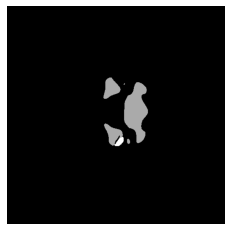

In [12]:
# visualize one of the layers randomly picked
i = np.random.randint(depth-1)
from collections import Counter
print(f"Plotting layer {i}")
print(f"Counts {np.unique(image_mask[:, :, i], return_counts=True)}")

show_3d_image_slice(
    image_data=image_mask,
    slice=i
)

In [13]:
# labels from the masking of segmentation dataset
segmented_labels: dict = {
  "C1": 1,
  "C2": 2,
  "C3": 3,
  "C4": 4,
  "C5": 5,
  "C6": 6,
  "C7": 7,
  "T1": 8,
  "T2": 9,
  "T3": 10,
  "T4": 11,
  "T5": 12,
  "T6": 13,
  "T7": 14,
  "T8": 15,
  "T9": 16,
  "T10": 17,
  "T11": 18,
  "T12": 19,
  "ELSE": 0
}

np.unique(image_mask)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint16)

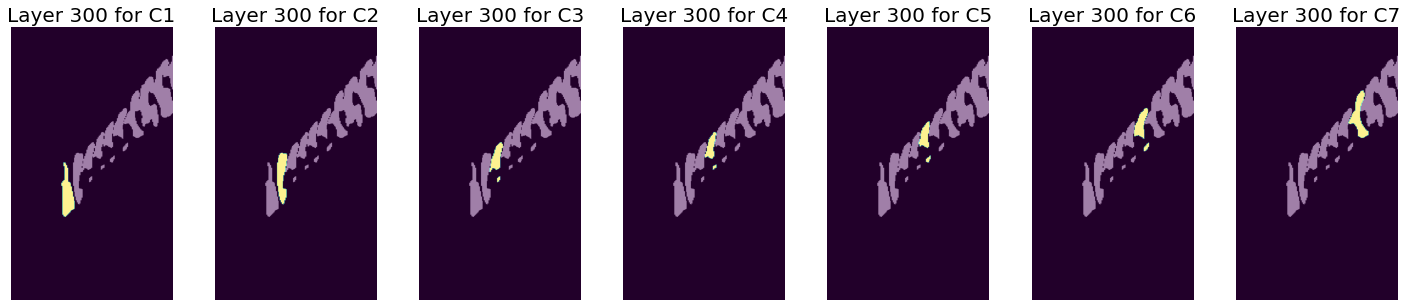

In [14]:
# have a neck level view by selecting layer we are sure has side view
layer = 300

fig, ax = plt.subplots(nrows=1, ncols=7, figsize=(20,15))
for i in range(7):
  img_label_str = list(segmented_labels.keys())[i]
  img = image_mask[layer, :, :]
  mask = np.where(img == segmented_labels[img_label_str], 255, 0)
  ax[i].imshow(mask)
  ax[i].imshow(image_mask[layer, :, :]>0, cmap="gray", alpha=0.5)
  ax[i].set_title(f"Layer {layer} for {img_label_str}", fontsize=20)
  ax[i].axis('off')
plt.tight_layout()
plt.show()

The images above show the segmentation masks from a slice of a layer of an image. These segmentations represent where each pixel of each vertebrae is where yellow is the given vertebra and purple is all the other vertebrae. This is a neck side view of all the vertebrae for a given slice at a given layer. We got this view by taking a layer of a 3D image from a randomly sampled image whose segmentation mask we have from the segmentation dataset. This segmentation is important because we can teach the model what each of the vertebrae looks like from different perspectives. This process is called image segmentation and we will specifically use semantic segmentation (more on this later). This then helps us label all the training images before classifying whether they have a fracture or not.

### Load the jpeg files

In [15]:
def read_training_study(path: str) -> np.array:
  """
  Reads a particular folder of a given study
  and returns a 3D array of the medical images
  stacked on top of each other.

  :param path: The path to the study folder
  """
  study_images: list = []
  images: list = sorted(
      os.listdir(path), 
      key=lambda x: int(x.split('.')[0])  # Sort the image names as numbers
  )

  for image in images:
    study_images.append(
        mpimg.imread(os.path.join(path, image))
    )

  return np.flip(np.array(study_images).T, axis=1)

In [16]:
train_study_data = read_training_study(
    path=seg_df.loc[ind, "training"]
)
train_study_data.shape

(512, 512, 303)

In [17]:
train_study_data.shape, image_mask.shape

((512, 512, 303), (512, 512, 303))

In [18]:
train_study_data.shape[2]

303

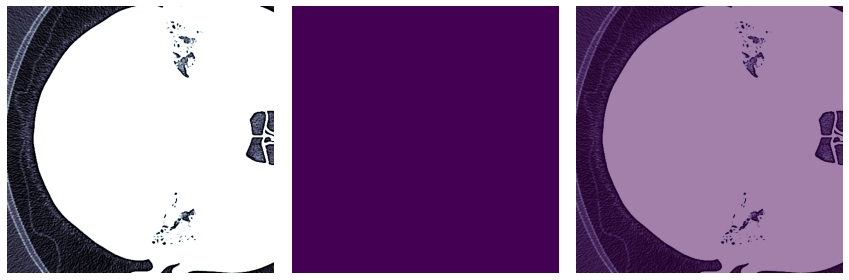

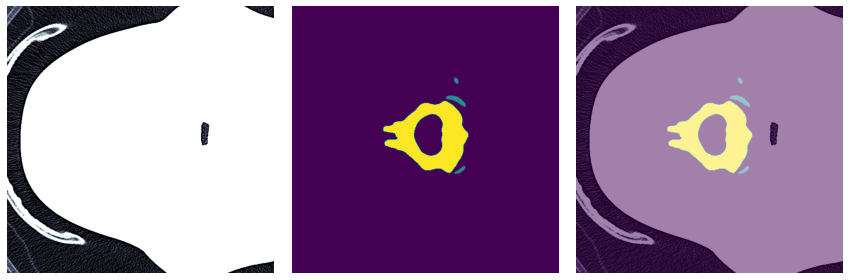

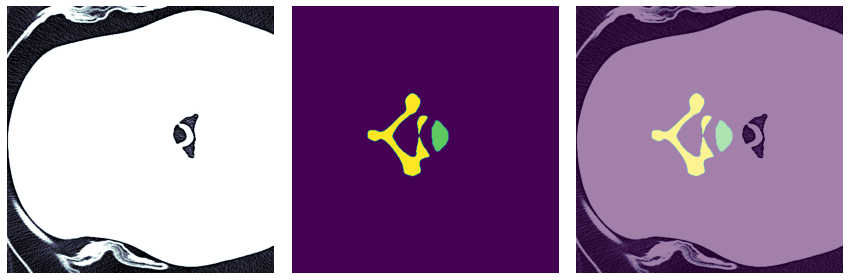

In [19]:
for slice in [50, 120, 160]:

  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

  ax1.imshow(
      train_study_data[:, :, slice],
      cmap=plt.cm.bone
  )
  ax1.axis("off")

  ax2.imshow(image_mask[:, :, slice])
  ax2.axis("off")

  ax3.imshow(
      train_study_data[:, :, slice],
      cmap=plt.cm.bone
  )
  ax3.imshow(
      image_mask[:, :, slice], 
      alpha=0.5
  )
  ax3.axis("off")

  # adjust spacing between subplots
  plt.tight_layout()
  plt.show()

In [20]:
# Get the number of slices in each study
seg_df["slices"] = seg_df.index.map(
    lambda study_id: all_segs[study_id].shape[2]
)
seg_df.head(3)

<ipython-input-20-6cef9566be36>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seg_df["slices"] = seg_df.index.map(


,segmentations,training,patient_overall,C1,C2,C3,C4,C5,C6,C7,slices
StudyInstanceUID,,,,,,,,,,,
1.2.826.0.1.3680043.10633,/content/gdrive/MyDrive/Tutorial_Session/hadav...,/content/gdrive/MyDrive/Tutorial_Session/hadav...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,429
1.2.826.0.1.3680043.10921,/content/gdrive/MyDrive/Tutorial_Session/hadav...,/content/gdrive/MyDrive/Tutorial_Session/hadav...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,339
1.2.826.0.1.3680043.11827,/content/gdrive/MyDrive/Tutorial_Session/hadav...,/content/gdrive/MyDrive/Tutorial_Session/hadav...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,208


In [21]:
train_studies, test_studies = train_test_split(seg_df)

display(train_studies.shape)
display(test_studies.shape)

(65, 11)

(22, 11)

In [22]:
display(train_studies)
display(test_studies)

,segmentations,training,patient_overall,C1,C2,C3,C4,C5,C6,C7,slices
StudyInstanceUID,,,,,,,,,,,
1.2.826.0.1.3680043.3992,/content/gdrive/MyDrive/Tutorial_Session/hadav...,/content/gdrive/MyDrive/Tutorial_Session/hadav...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252
1.2.826.0.1.3680043.32590,/content/gdrive/MyDrive/Tutorial_Session/hadav...,/content/gdrive/MyDrive/Tutorial_Session/hadav...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,269
1.2.826.0.1.3680043.8024,/content/gdrive/MyDrive/Tutorial_Session/hadav...,/content/gdrive/MyDrive/Tutorial_Session/hadav...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,273
1.2.826.0.1.3680043.32280,/content/gdrive/MyDrive/Tutorial_Session/hadav...,/content/gdrive/MyDrive/Tutorial_Session/hadav...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,279
1.2.826.0.1.3680043.15206,/content/gdrive/MyDrive/Tutorial_Session/hadav...,/content/gdrive/MyDrive/Tutorial_Session/hadav...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,334
...,...,...,...,...,...,...,...,...,...,...,...
1.2.826.0.1.3680043.26898,/content/gdrive/MyDrive/Tutorial_Session/hadav...,/content/gdrive/MyDrive/Tutorial_Session/hadav...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,593
1.2.826.0.1.3680043.16919,/content/gdrive/MyDrive/Tutorial_Session/hadav...,/content/gdrive/MyDrive/Tutorial_Session/hadav...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,409
1.2.826.0.1.3680043.17960,/content/gdrive/MyDrive/Tutorial_Session/hadav...,/content/gdrive/MyDrive/Tutorial_Session/hadav...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,271


,segmentations,training,patient_overall,C1,C2,C3,C4,C5,C6,C7,slices
StudyInstanceUID,,,,,,,,,,,
1.2.826.0.1.3680043.5002,/content/gdrive/MyDrive/Tutorial_Session/hadav...,/content/gdrive/MyDrive/Tutorial_Session/hadav...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,399
1.2.826.0.1.3680043.32071,/content/gdrive/MyDrive/Tutorial_Session/hadav...,/content/gdrive/MyDrive/Tutorial_Session/hadav...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,263
1.2.826.0.1.3680043.32434,/content/gdrive/MyDrive/Tutorial_Session/hadav...,/content/gdrive/MyDrive/Tutorial_Session/hadav...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,348
1.2.826.0.1.3680043.780,/content/gdrive/MyDrive/Tutorial_Session/hadav...,/content/gdrive/MyDrive/Tutorial_Session/hadav...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,195
1.2.826.0.1.3680043.8744,/content/gdrive/MyDrive/Tutorial_Session/hadav...,/content/gdrive/MyDrive/Tutorial_Session/hadav...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,164
1.2.826.0.1.3680043.12292,/content/gdrive/MyDrive/Tutorial_Session/hadav...,/content/gdrive/MyDrive/Tutorial_Session/hadav...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,341
1.2.826.0.1.3680043.21321,/content/gdrive/MyDrive/Tutorial_Session/hadav...,/content/gdrive/MyDrive/Tutorial_Session/hadav...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,673
1.2.826.0.1.3680043.32370,/content/gdrive/MyDrive/Tutorial_Session/hadav...,/content/gdrive/MyDrive/Tutorial_Session/hadav...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,262
1.2.826.0.1.3680043.26498,/content/gdrive/MyDrive/Tutorial_Session/hadav...,/content/gdrive/MyDrive/Tutorial_Session/hadav...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,363


In [23]:
# Generate rows for each slice, i.e each image
train_slices = pd.DataFrame(
    train_studies.values.repeat(train_studies["slices"], axis=0),
    columns=train_studies.columns
)

train_slices['slice'] = (train_slices.groupby([*train_slices]).cumcount()-1).where(
    train_slices.duplicated(), 
    train_slices['slices']
)
train_slices = train_slices[train_slices["slices"] != train_slices["slice"]]


test_slices = pd.DataFrame(
    test_studies.values.repeat(test_studies["slices"], axis=0),
    columns=test_studies.columns
)

test_slices['slice'] = (test_slices.groupby([*test_slices]).cumcount()-1).where(
    test_slices.duplicated(), 
    test_slices['slices']
)
test_slices = test_slices[test_slices["slices"] != test_slices["slice"]]

display(train_slices.head(3))
display(train_slices.shape)
display(test_slices.head(3))
display(test_slices.shape)

,segmentations,training,patient_overall,C1,C2,C3,C4,C5,C6,C7,slices,slice
1,/content/gdrive/MyDrive/Tutorial_Session/hadav...,/content/gdrive/MyDrive/Tutorial_Session/hadav...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252,0
2,/content/gdrive/MyDrive/Tutorial_Session/hadav...,/content/gdrive/MyDrive/Tutorial_Session/hadav...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252,1
3,/content/gdrive/MyDrive/Tutorial_Session/hadav...,/content/gdrive/MyDrive/Tutorial_Session/hadav...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252,2


(22406, 12)

,segmentations,training,patient_overall,C1,C2,C3,C4,C5,C6,C7,slices,slice
1,/content/gdrive/MyDrive/Tutorial_Session/hadav...,/content/gdrive/MyDrive/Tutorial_Session/hadav...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,399,0
2,/content/gdrive/MyDrive/Tutorial_Session/hadav...,/content/gdrive/MyDrive/Tutorial_Session/hadav...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,399,1
3,/content/gdrive/MyDrive/Tutorial_Session/hadav...,/content/gdrive/MyDrive/Tutorial_Session/hadav...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,399,2


(7339, 12)

In [24]:
tf.image.resize(
      np.expand_dims(
      all_segs["1.2.826.0.1.3680043.12281"][:, :, 200],
      axis=-1
  ),
  (128, 128)
).shape

TensorShape([128, 128, 1])

In [25]:
np.unique(tf.image.resize(
      np.expand_dims(
      all_segs["1.2.826.0.1.3680043.12281"][:, :, 200],
      axis=-1
  ),
  (128, 128)
))

array([0.  , 1.  , 1.25, 2.  , 2.5 , 3.  , 3.75, 4.  , 5.  ],
      dtype=float32)

In [26]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  return input_image, input_mask


def __base_load_image_mask(
    data_row: pd.Series
  ) -> "tuple[np.array, np.array]":
  """
  Loads the image and mask located in a given row within the given dataframe

  :param data_row: The data row to get images for

  :returns the image, and the mask
  """
  images: np.array = read_training_study(data_row["training"])

  image = tf.image.resize(
      # Add an additional channel to the image
      np.expand_dims(
          images[:, :, data_row["slice"]], 
          axis=-1
      ),
      (128, 128)
  )

  study_id: str = data_row["segmentations"].split("/")[-1].strip(".npy")
  
  mask = tf.image.resize(
      # Add an additional channel to the image
      np.expand_dims(
        all_segs[study_id][:, :, data_row["slice"]],
        axis=-1
      ),
      (128, 128)
  )

  return image, mask

def train_data_generator():
    for i, data_row in train_slices.iterrows():
      input_image, input_mask = __base_load_image_mask(
          data_row=data_row
      )

      # randomly flip some of the images and masks
      if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

      input_image, input_mask = normalize(input_image, input_mask)

      yield input_image, input_mask

def test_data_generator():
  for i, data_row in test_slices.iterrows():

    input_image, input_mask = __base_load_image_mask(
        data_row=data_row
    )

    input_image, input_mask = normalize(input_image, input_mask)

    yield input_image, input_mask

In [27]:
train_dataset = tf.data.Dataset.from_generator(
    generator = train_data_generator, 
    output_types = (tf.float32, tf.uint8),
    output_shapes = ((128, 128, 1), (128, 128, 1))
).map(
    lambda img, mask: (img, mask),
    num_parallel_calls=tf.data.AUTOTUNE
)


test_dataset = tf.data.Dataset.from_generator(
    generator=test_data_generator, 
    output_types=(tf.float32, tf.uint8),
    output_shapes = ((128, 128, 1), (128, 128, 1))
).map(
    lambda img, mask: (img, mask),
    num_parallel_calls=tf.data.AUTOTUNE
)

In [28]:
BATCH_SIZE = 16
BUFFER_SIZE = 1000
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = test_dataset.take(3000).batch(BATCH_SIZE)
test_batches = test_dataset.skip(3000).take(669).batch(BATCH_SIZE)

In [29]:
next(iter(train_batches))

(<tf.Tensor: shape=(16, 128, 128, 1), dtype=float32, numpy=
 array([[[[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         ...,
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]]],
 
 
        [[[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         

ValueError: ignored

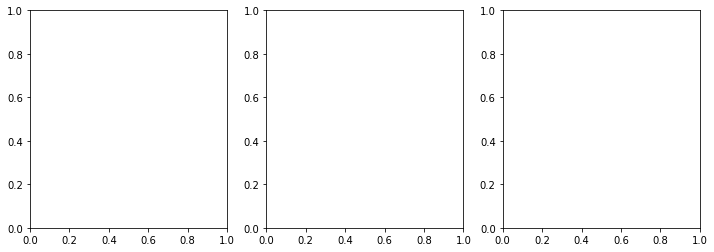

In [30]:
for img, mask in train_dataset.take(1):
  for i in range(img.shape[0]):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
    sample_image, sample_mask = img[i], mask[i]

    ax1.imshow(
        tf.keras.preprocessing.image.array_to_img(sample_image),
        cmap=plt.cm.bone
    )
    ax1.axis("off")
    
    ax2.imshow(tf.keras.preprocessing.image.array_to_img(sample_mask))
    ax2.axis("off")

    ax3.imshow(
        tf.keras.preprocessing.image.array_to_img(sample_image),
        cmap=plt.cm.bone
    )
    ax3.imshow(
        tf.keras.preprocessing.image.array_to_img(sample_mask), 
        alpha=0.5
    )
    ax3.axis("off")

    # adjust spacing between subplots
    plt.tight_layout()
    plt.show()

In [ ]:
def show_img_mask_predicted(display_list: list):
    titles = ["Input Image", "True Mask", "Predicted Mask"]

    for i in range(len(display_list)):
      plt.subplot(1, len(display_list), i+1)
      plt.title(titles[i])
      plt.imshow(
          tf.keras.preprocessing.image.array_to_img(display_list[i])
      )
      plt.axis("off")
      
    plt.show()

In [ ]:
show_img_mask_predicted([sample_image, sample_mask])

## Model Building and Training

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

## U-Net Building Blocks

In [ ]:
def double_conv_block(x, n_filters):

    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

    return x

In [ ]:
def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)

    return f, p

In [ ]:
def upsample_block(x, conv_features, n_filters):
    # upsample
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    # concatenate 
    x = layers.concatenate([x, conv_features])
    # dropout
    x = layers.Dropout(0.3)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)

    return x

In [ ]:
def build_unet_model():

    # inputs
    # inputs = layers.Input(shape=(512,512,3))

    inputs = layers.Input(shape=(128,128,1))


    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)

    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)

    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)

    # outputs
    outputs = layers.Conv2D(1, 1, padding="same", activation = "softmax")(u9)

    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model

In [ ]:
unet_model = build_unet_model()

In [ ]:
unet_model.summary()

In [ ]:
# compile and train unet
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                   loss="sparse_categorical_crossentropy",
                   metrics="accuracy")

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=0)
  return pred_mask

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = unet_model.predict(image)
      show_img_mask_predicted([image[0], mask[0], create_mask(pred_mask)])
  else:
    show_img_mask_predicted(
      [
        sample_image, 
        sample_mask,
        create_mask(
            unet_model.predict(
                np.expand_dims(
                  sample_image,
                  axis=0
                )
              )
            )
      ]
    )

In [ ]:
show_predictions()

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [ ]:
BATCH_SIZE = 16
BUFFER_SIZE = 1000
NUM_EPOCHS = 10
TRAIN_LENGTH = train_slices.shape[0]
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VAL_SUBSPLITS = 5
TEST_LENTH = test_slices.shape[0]
VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS
model_history = unet_model.fit(train_batches,
                              epochs=NUM_EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              validation_steps=VALIDATION_STEPS,
                              validation_data=test_batches,
                              callbacks=[DisplayCallback()])

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [ ]:
def resize(input_image, input_mask):
   input_image = tf.image.resize(input_image, (128, 128), method="nearest")
   input_mask = tf.image.resize(input_mask, (128, 128), method="nearest")

   return input_image, input_mask

In [ ]:
def augment(input_image, input_mask):
   if tf.random.uniform(()) > 0.5:
       # Random flipping of the image and mask
       input_image = tf.image.flip_left_right(input_image)
       input_mask = tf.image.flip_left_right(input_mask)

   return input_image, input_mask

In [ ]:
def normalize(input_image, input_mask):
   input_image = tf.cast(input_image, tf.float32) / 255.0
   input_mask -= 1
   return input_image, input_mask

In [ ]:
def load_image_train(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = augment(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)

   return input_image, input_mask

def load_image_test(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)

   return input_image, input_mask

In [ ]:
train_dataset = dataset["train"].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = dataset["test"].map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
train_batches

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = test_dataset.take(3000).batch(BATCH_SIZE)
test_batches = test_dataset.skip(3000).take(669).batch(BATCH_SIZE)

In [ ]:
train_batches

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.uint8, name=None))>

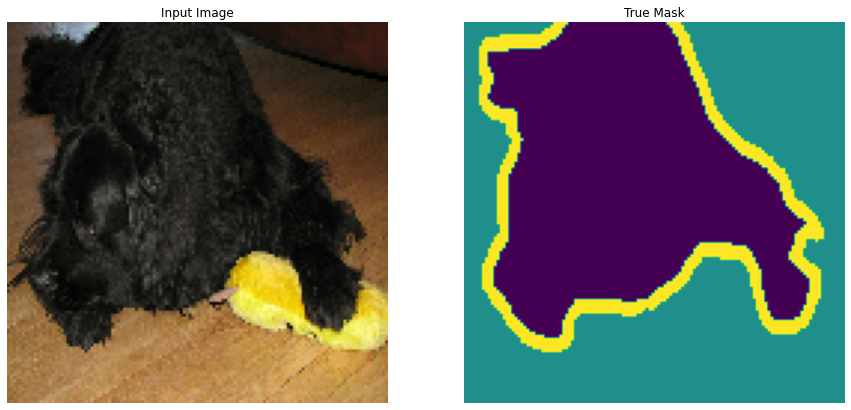

In [ ]:
def display(display_list):
 plt.figure(figsize=(15, 15))

 title = ["Input Image", "True Mask", "Predicted Mask"]

 for i in range(len(display_list)):
   plt.subplot(1, len(display_list), i+1)
   plt.title(title[i])
   plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
   plt.axis("off")
 plt.show()

sample_batch = next(iter(train_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])

In [ ]:
def double_conv_block(x, n_filters):

   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

   return x

In [ ]:
def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)

   return f, p

In [ ]:
def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   x = layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)

   return x

In [ ]:
def build_unet_model(): 
  # inputs
  inputs = layers.Input(shape=(128,128,3))

  # encoder: contracting path - downsample
  # 1 - downsample
  f1, p1 = downsample_block(inputs, 64)
  # 2 - downsample
  f2, p2 = downsample_block(p1, 128)
  # 3 - downsample
  f3, p3 = downsample_block(p2, 256)
  # 4 - downsample
  f4, p4 = downsample_block(p3, 512)

  # 5 - bottleneck
  bottleneck = double_conv_block(p4, 1024)

  # decoder: expanding path - upsample
  # 6 - upsample
  u6 = upsample_block(bottleneck, f4, 512)
  # 7 - upsample
  u7 = upsample_block(u6, f3, 256)
  # 8 - upsample
  u8 = upsample_block(u7, f2, 128)
  # 9 - upsample
  u9 = upsample_block(u8, f1, 64)

  # outputs
  outputs = layers.Conv2D(3, 1, padding="same", activation = "softmax")(u9)

  # unet model with Keras Functional API
  unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

  return unet_model

In [ ]:
unet_model = build_unet_model()

In [ ]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics="accuracy")

In [ ]:
NUM_EPOCHS = 20

TRAIN_LENGTH = info.splits["train"].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

VAL_SUBSPLITS = 5
TEST_LENTH = info.splits["test"].num_examples
VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS

model_history = unet_model.fit(train_batches,
                              epochs=NUM_EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              validation_steps=VALIDATION_STEPS,
                              validation_data=test_batches)

Epoch 1/20


In [ ]:
train_batches

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.uint8, name=None))>

In [ ]:
next(iter(train_batches))

(<tf.Tensor: shape=(64, 128, 128, 3), dtype=float32, numpy=
 array([[[[0.69803923, 0.7019608 , 0.78039217],
          [0.7058824 , 0.70980394, 0.7882353 ],
          [0.64705884, 0.6509804 , 0.7294118 ],
          ...,
          [0.2901961 , 0.19215687, 0.16470589],
          [0.654902  , 0.53333336, 0.4627451 ],
          [0.7372549 , 0.6039216 , 0.5058824 ]],
 
         [[0.6392157 , 0.6431373 , 0.72156864],
          [0.5882353 , 0.5921569 , 0.67058825],
          [0.5921569 , 0.59607846, 0.6745098 ],
          ...,
          [0.34901962, 0.26666668, 0.24705882],
          [0.21568628, 0.11372549, 0.0627451 ],
          [0.6431373 , 0.5294118 , 0.46666667]],
 
         [[0.58431375, 0.5882353 , 0.6666667 ],
          [0.5921569 , 0.59607846, 0.6745098 ],
          [0.6627451 , 0.6666667 , 0.74509805],
          ...,
          [0.54901963, 0.47843137, 0.47843137],
          [0.20392157, 0.12156863, 0.10196079],
          [0.41960785, 0.32941177, 0.29803923]],
 
         ...,
 
      